## Importing Libraries

In [1]:
import os
import random
from collections import deque
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from alive_progress import alive_it

## display The Lunar Lander without training performence

In [2]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

d:\programs\Anaconda\envs\gymenv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Creating the agent class and the agent

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices())
print(tf.__version__)

env = gym.make("LunarLander-v2")

SEED = 0

def set_seeds(seed=None):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    if hasattr(env, 'seed'):
        env.seed(seed)
    if hasattr(env.action_space, 'seed'):
        env.action_space.seed(seed)

set_seeds(SEED)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.16.1


In [4]:
class DQLAgent:
    def __init__(self, env, gamma=0.99):
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = 0.998
        self.epsilon_min = 0.01
        self.tot_reward = []
        self.batch_size = 64
        self.memory = deque(maxlen=500000)
        self.osn = env.observation_space.shape[0]
        self.opt = Adam(learning_rate=0.001)
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.osn, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=self.opt)
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        state = np.reshape(state, [1, self.osn])
        action = self.model.predict(state, verbose=0)
        return np.argmax(action[0])

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay_batch(self):
        batch = random.sample(self.memory, self.batch_size)

        state = np.squeeze(np.array([i[0] for i in batch]))
        action = np.array([i[1] for i in batch])
        reward = np.array([i[2] for i in batch])
        next_state = np.squeeze(np.array([i[3] for i in batch]))
        done = np.array([i[4] for i in batch])

        q_val = reward + self.gamma * np.amax(self.model.predict_on_batch(next_state), \
                                               axis=1) * (1 - done)
        target = self.model.predict_on_batch(state)
        idx = np.arange(self.batch_size)
        target[[idx], [action]] = q_val

        self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        for e, _ in enumerate(alive_it(range(episodes),bar = 'smooth', spinner = 'vertical' ,force_tty=True)):
            state = env.reset()[0]  # Extract the first element of the tuple
            state = np.reshape(state, [1, self.osn])
            t_reward = 0
            max_steps = 1000
            for step in range(max_steps):
                action = self.act(state)
                next_state, reward, done, info, _ = env.step(action)  # Accept the 'info' variable
                next_state = np.reshape(next_state, [1, self.osn])  # Extract the first element of the tuple
                self.memorize(state, action, reward, next_state, done)
                state = next_state
                t_reward += reward
                if len(self.memory) > self.batch_size:
                    self.replay_batch()
                if done:
                    break

            self.tot_reward.append(t_reward)

            if np.mean(self.tot_reward[-100:]) >= 250:
                print('*** Environment solved ***')
                break

    def save_model(self, name):
        self.model.save(name)

## Ploting the agent's reward progress

d:\programs\Anaconda\envs\gymenv\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


on 363: *** Environment solved ***                                              
|██████████████████████⚠︎                 | (!) 363/660 [55%] in 5:24:34.6 (0.02/


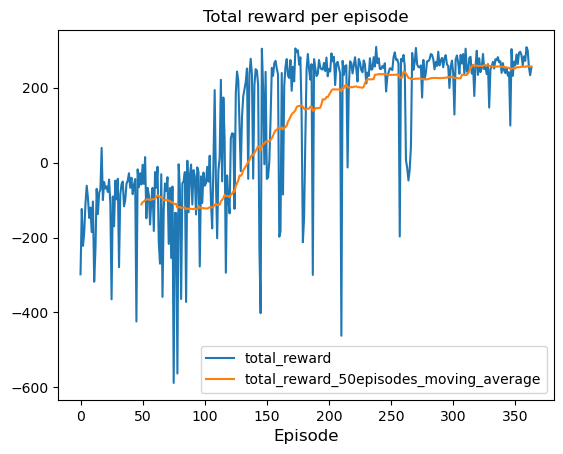

In [5]:
agent = DQLAgent(env)
episodes = 660
agent.learn(episodes)
agent.save_model('LunarLanderDQL.keras')

df = pd.DataFrame(np.array(agent.tot_reward), columns=['total_reward'])
df['total_reward_50episodes_moving_average'] = df['total_reward'].rolling(window=50).mean()
df.plot(title='Total reward per episode')
plt.xlabel('Episode', fontsize=12)
plt.show()

## display The Trained Lunar Lander performence

In [12]:
model_path = os.path.join(os.getcwd(), 'LunarLanderDQL.keras')
model = load_model(model_path)

# Create the environment
env = gym.make('LunarLander-v2', render_mode="human")

# Reset the environment and get the initial state
state = env.reset()[0]  # Extract the first element of the tuple

# Get the observation space size
observation_space = env.observation_space.shape[0]

# Play the game until it's done
done = False
while not done:
    # Create a 1D array with the state value
    state = state.reshape(1, observation_space)

    # Select the action with the highest predicted Q-value
    action = np.argmax(model.predict(state, verbose=0)[0])

    # Render the environment
    env.render()

    # Step the environment and get the next state, reward, done flag, and info
    state, reward, done, info, _ = env.step(action)

# Close the environment
env.close()